# Lab 3 - Chemotaxis

This lab is designed to get you familiar with the basics of chemotaxis.  We will compare our random agent with a gradient searcher who operates akin to a simple bacteria agent.

There are three goals here.

1. Extrapolate on scent signals and gradients.
2. Examine exploration for targets with a variable scent in an open field.
3. Look at the robustness of chemotaxis to noise.

## Background

In this lab we return to _taxic explorations_. We visit the sniff world (aka _ScentGrid_) and at what happens when sense signals are not just noisy, but partially observed. In otherwords, when there is distortion in the channel of information.

Our environment this times just deletes scent information from the grid, with a probability $(1- p_{scent})$. The noisy background is of course unaffected by this deletion.


## Bacteria again?
Our basic model of bacterial exploration is as simple as can be.

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_


**Structured randomness and chemotaxis**

In lab 2 we played with a random search agent that wandered using Brownian motion. Here we will introuce a new random agent that moves according to Levy walks.

* A Levy walk is a continuing process of random movement where at each "step" of movement, a direction of and distance of movement is chosen randomly. The distance $\delta_i$ of movement at each time step $i$ is sampled from the random distribution as follows: $\delta_i = {u_i}^{-\frac{1}{\gamma}}$, where $u_i \sim N(\mu,\sigma)$ and $\gamma > 1$.

Our _chemotaxis_ agent (_AccumulatorGradientDiscrete_) tries to directly estimate the gradient of the scent $\nabla$  by comparing the level of scent at the last grid position it occupied to the current scent level ($o$). By last position here we mean the last position when it moved last.

$$\nabla \approx o_t - o_{t-1}$$

Our chemotaxis agent thus behaves as follows:

- When the scent gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_ evironment.

### Costly cognition
The _chemotaxis_ agents will use an evidence accumulation process that we will explore in more detail later. This uses the iterative accumulation of evidence from sensory signals to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature.

For the _randotaxis_ agent number of steps means the number of steps or actions the agent takes.


## Section - Setup

First let's set things up for the two parts of the lab. You've done this before, so we don't need to specify each installation and module step.

In [1]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-8zlqawbh
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-8zlqawbh
  Resolved https://github.com/coaxlab/explorationlib to commit 51e93ea9a3866d32202fb912bc46f7fcb18e8a17
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=41444 sha256=7754bdd2b4ca1cb36331bce78b2cec68307dd056e34f03674e12d4b38e1300ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-ow9vflh0/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-ntmy6d_g
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-ntmy6d_g
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Simulating noisy \& missing scents


To build some intuition, let's plot the "scent" emitted by a single target. That same scent corrupts by 1/2 a standard deviation of noise. That same signal, with all but 10 percent of it deleted. That same signal corrupted by noise _and_ all but 10 percent of it deleted.

### Full Scent

Okay, let's first visualize what the scent diffusion around each target looks like in the environment using the diffusion parameters we have set up.

In [4]:
target_boundary = (10, 10)

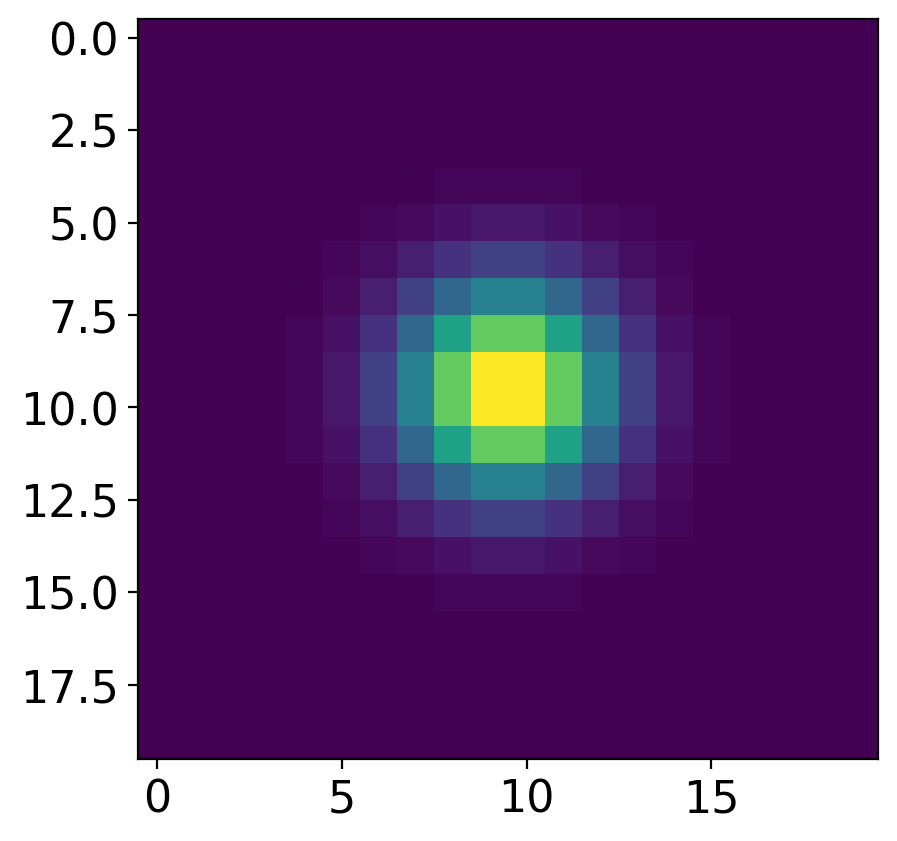

In [5]:
amplitude = 1

coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=amplitude, sigma=2)

plt.imshow(scent, interpolation=None)

### Noisy Scent

To corrupt the signal we can simply add more Gaussian noise. In this case we will use the *add_noise* function with a $\sigma=1$.

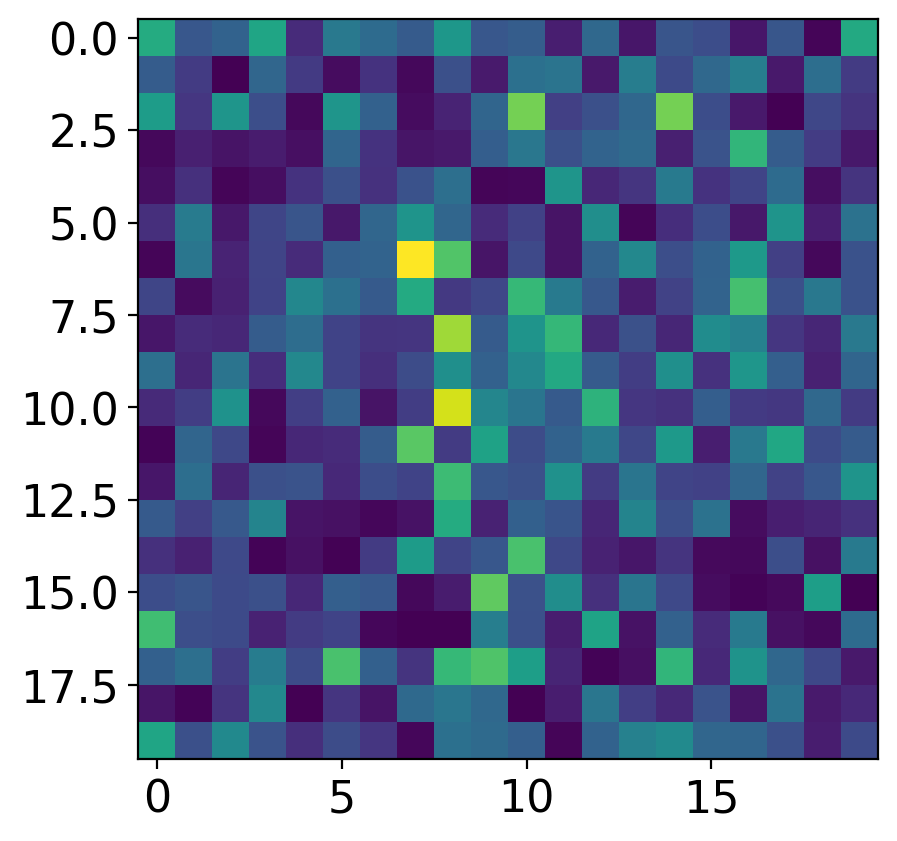

In [6]:
amplitude = 1
noise_sigma = 1.0

coord, scent = create_grid_scent_patches(target_boundary, p=1.0, amplitude=amplitude, sigma=2)
scent = add_noise(scent, noise_sigma)

plt.imshow(scent, interpolation=None)

Doesn't look resolvable does it? If you squint, maybe you can see it?

In order to confirm that there is signal there, let's take a look at the average over 100 noisy targets.

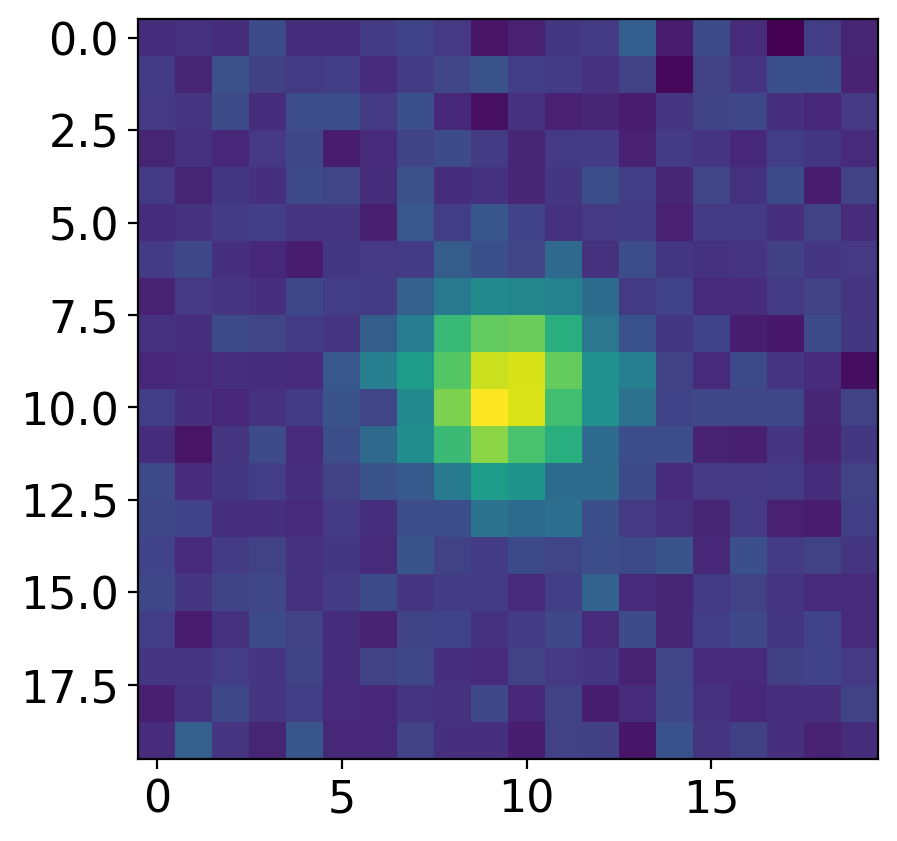

In [7]:
amplitude = 1
noise_sigma = 1.0
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=1.0, amplitude=1, sigma=2)
    scent = add_noise(scent, noise_sigma)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

### Missing Scent

We can further distort or corrup the signal by making some of the information simply missing. Imaging we're in our little agents acquatic environment and currents move some of the sent signal away.

Here we can control the probability of a scent molecule being detected at any point in space with the *p_scent* parameter.

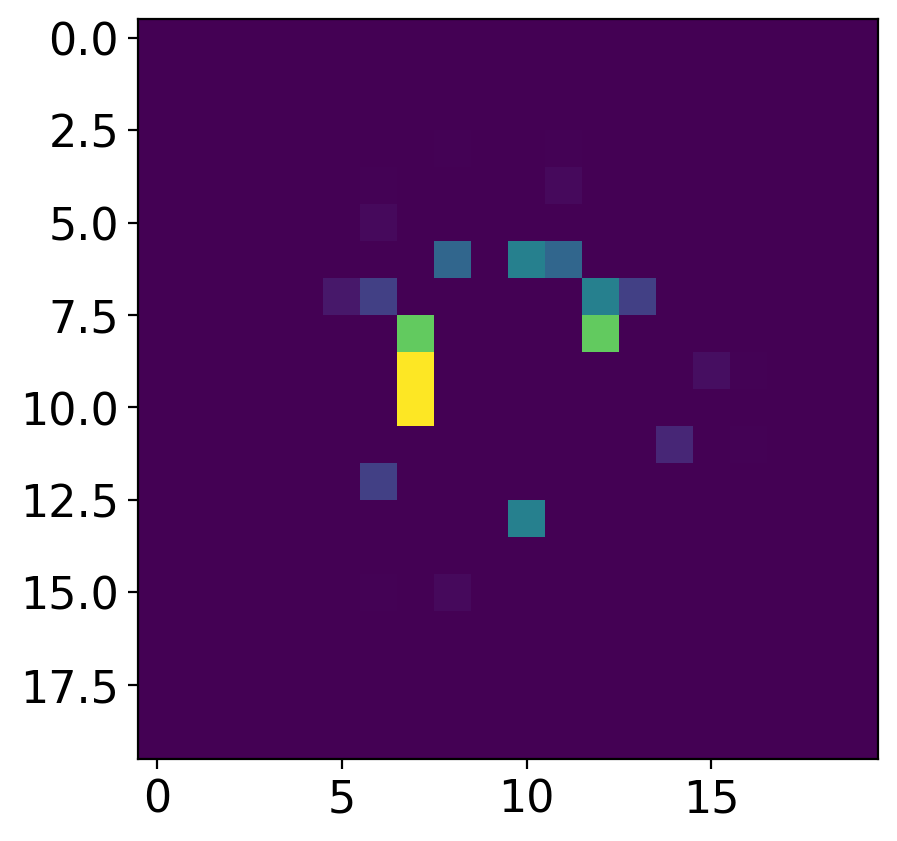

In [8]:
amplitude = 1000
p_scent = 0.1

coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=2)

plt.imshow(scent, interpolation=None)

Again, let's average across 100 targets to see what the modal resolvable scent would look like over samples.

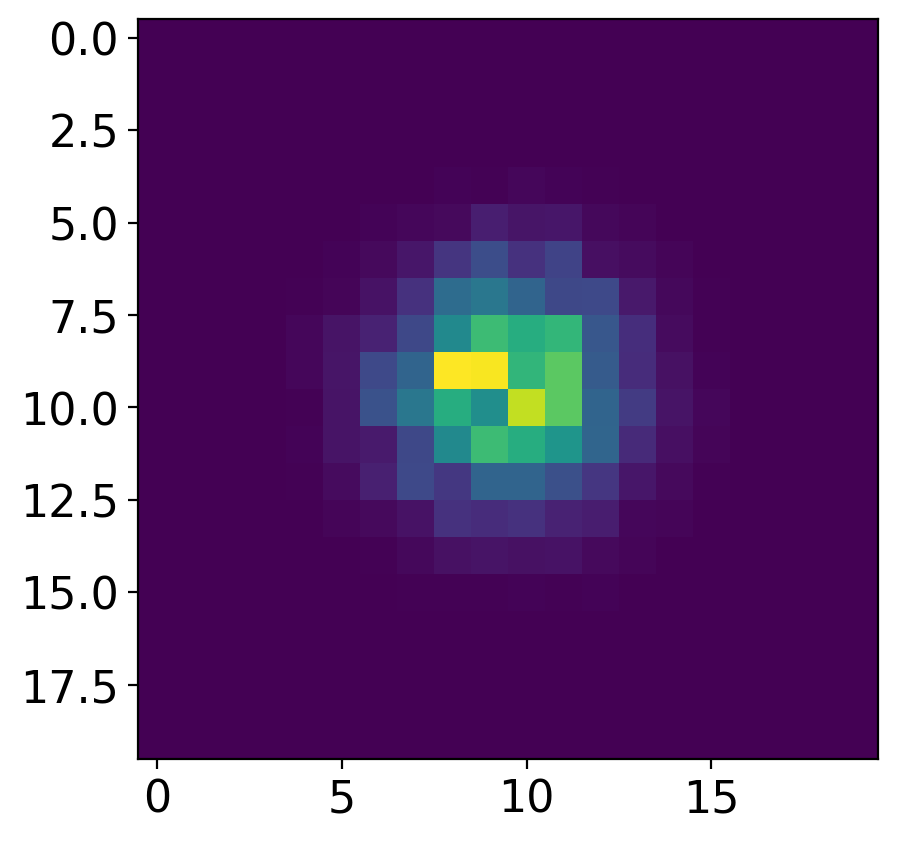

In [9]:
amplitude = 1
p_scent = 0.1
num_samples = 100

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=1, sigma=2)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

### Noisy *and* Missing Scent

Now let's see the most distorted signal we can: one with both Gaussian noise added *and* partially observed.

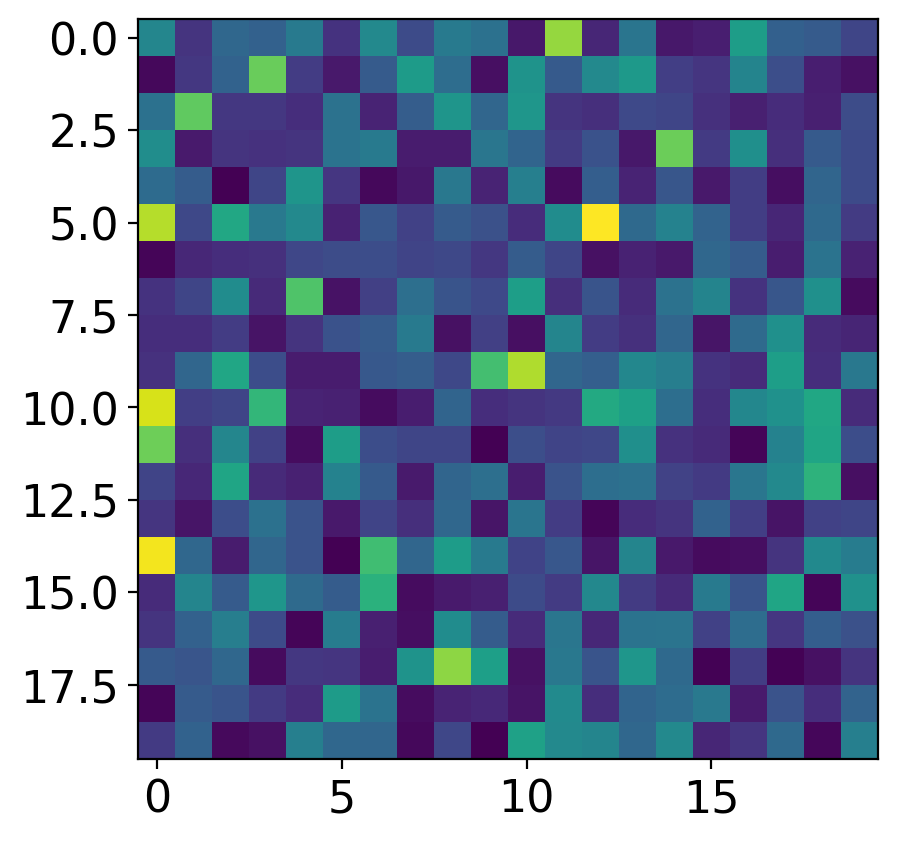

In [10]:
amplitude = 1
noise_sigma = 1
p_scent = 0.1

coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=amplitude, sigma=2)
scent = add_noise(scent, noise_sigma)

plt.imshow(scent, interpolation=None)

And again, let's look over the average. But given how much noise we have added, we will need to average over more samples to see the pattern. Let's increase *num_samples* to 1000.

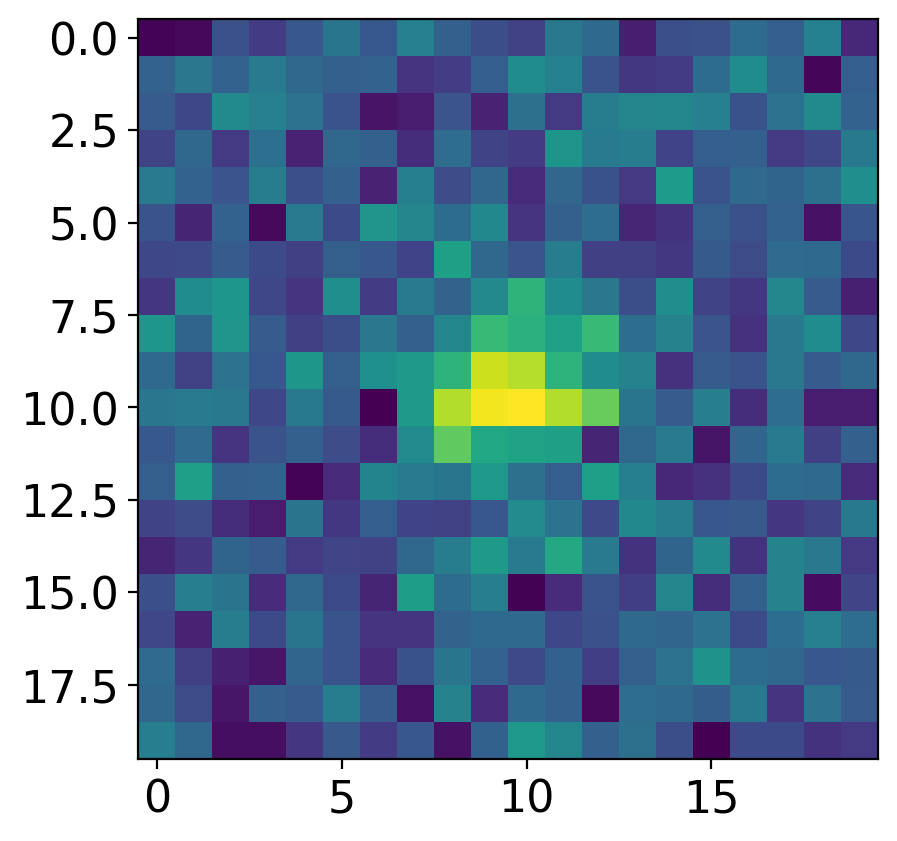

In [11]:
amplitude = 1
noise_sigma = 1
p_scent = 0.1
num_samples = 1000

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=p_scent, amplitude=1, sigma=2)
    scent = add_noise(scent, noise_sigma)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

So, pretty noisy but resolvable.

### Question 1.1

Adding noise and lowering detection probability both act to increase distortion to the signal channel that will be used by our agents. Will this help or hinder the agents that use sensory signals and/or information to drive their decisions? Explain your answer.

In [12]:
# Write your answer here, as a python comment

### Question 1.2

Re-run the Noisy *AND* Missing simulations above, playing with both of the *p_scent* and *noise_sigma* terms. Do this one at a time (i.e., when changing *p_scent* keep *noise_sigma=1*, when changign *noise_sigma* keep *p_scent=0.1*).

What are the values for each parameter that lead to a complete loss in the scent signal even when averaging across 1000 samples?

In [13]:
# Write your answer here, as a python comment

## Section 2 - Using Sensory Evidence To Explore


In this section we take on accumulating evidence as a policy for decision making in the form of simple chemotaxis with noisy sensors. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity.

In [14]:
# Noise and missing scents
p_scent = 0.1
noise_sigma = 1

# Shared
num_experiments = 100
num_steps = 400
seed_value = 5838

# ! (leave alone)
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Again we are working a scent grid environment where each target emits noisy chemical signals (scents) according to our definitions above.

Here's an example of our environment

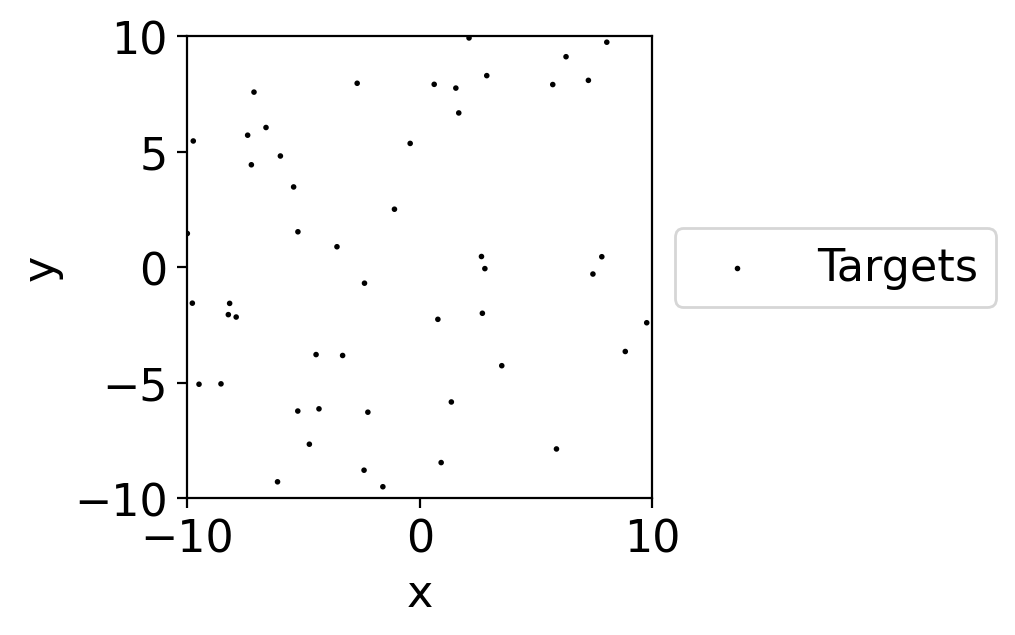

In [15]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

We will use 2 agents in these sims:

- Rando: Uses random Brownian motion search.
- Chemo: Uses only the detected scent gradient to make a decision.

How do these agents work? Check the explorationlib code for details.

* In the left panel on Colab, click on the file icon to access the file view for your Colab notebook.
* Click the ".." file to go up one level (if necessary) and then navigate to `/usr/local/lib/python3.7/dist-packages/explorationlib/agent.py` and double click the file (or just click the link in this bullet) to open up the library's code for defining exploration agents.
* Find the _DiffusionGrid_ and _AccumulatorGradientGrid_ functions to see how they are implemented.

In [16]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

drift_rate = 1
threshold = 3

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)


[5838]

Now let's run the experiments.

In [17]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot an example experiment. Here I'm choosing the second run for each agent.

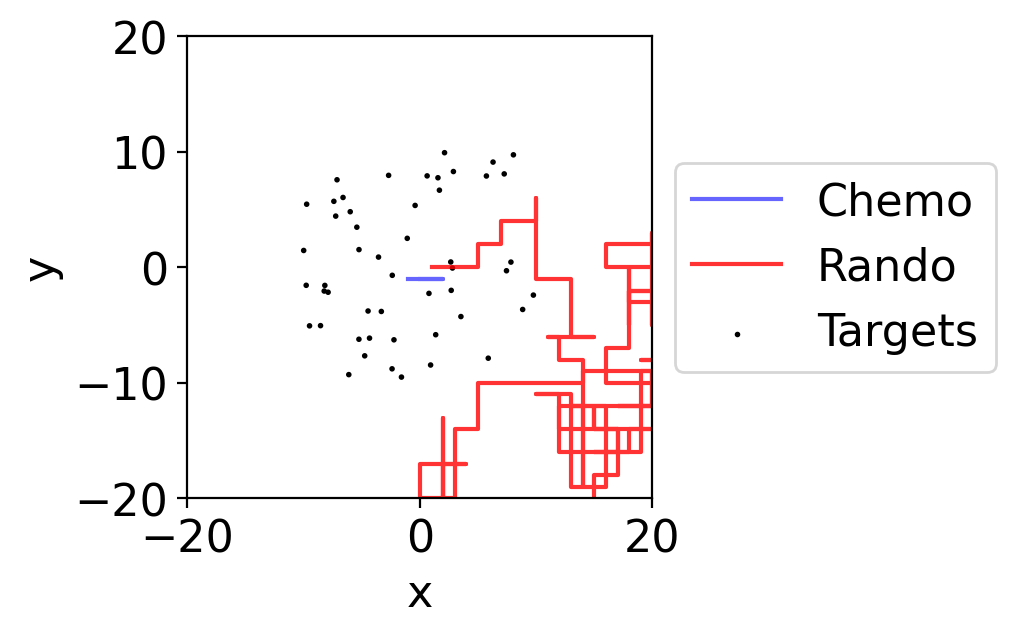

In [18]:
plot_boundary = (20, 20)

# -
num_experiment = 2
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Hard to distinguish their individual behaviors, but our agents seem to be exploring.

Now let's evaluate some metrics of performance.

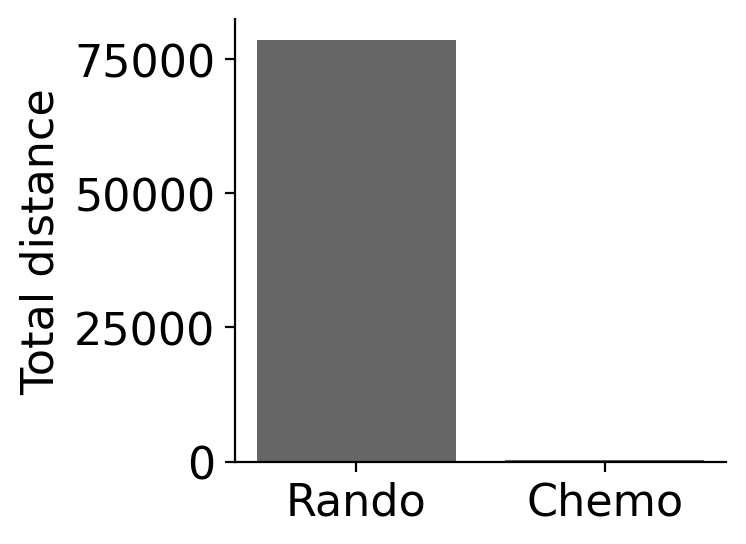

In [19]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += r["agent_total_l"][-1]
    scores.append(l)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

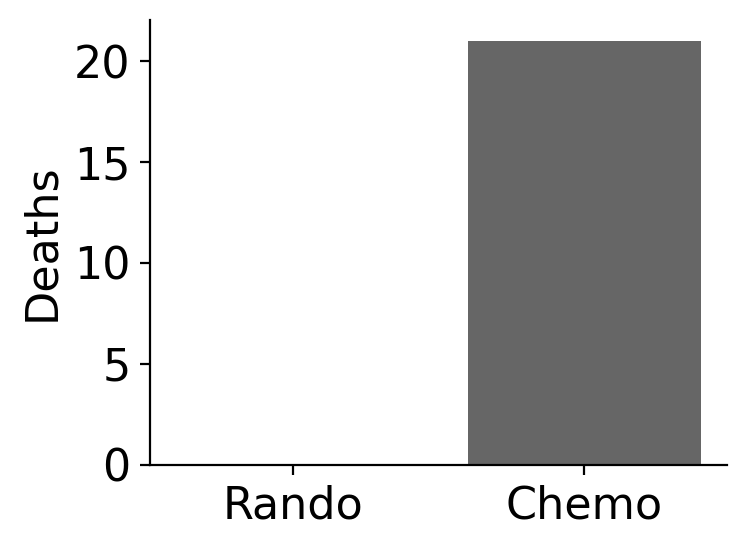

In [20]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

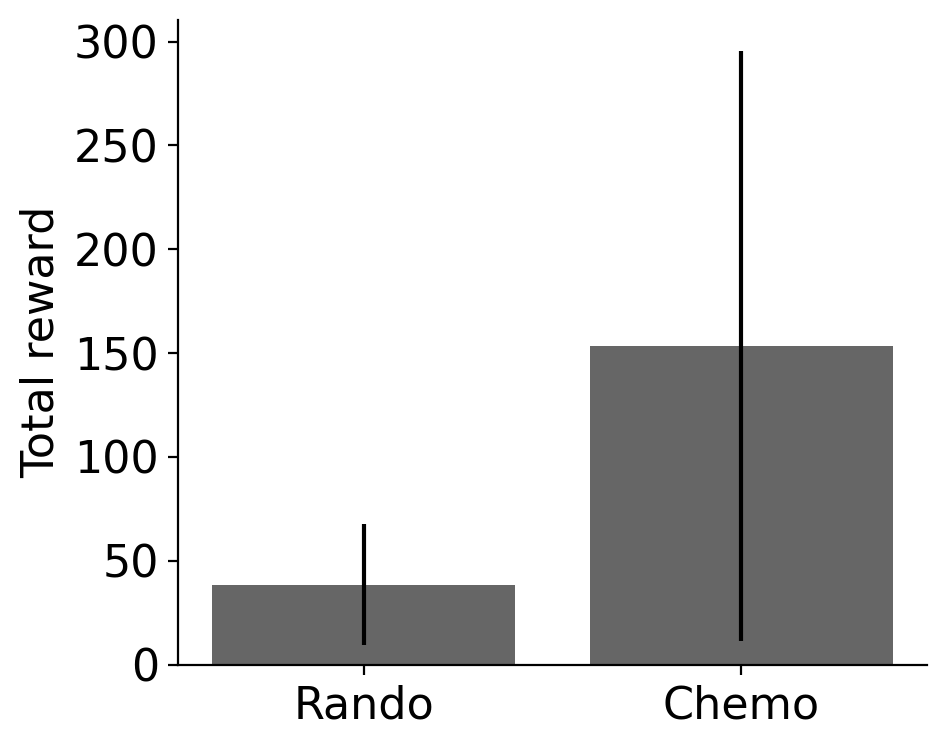

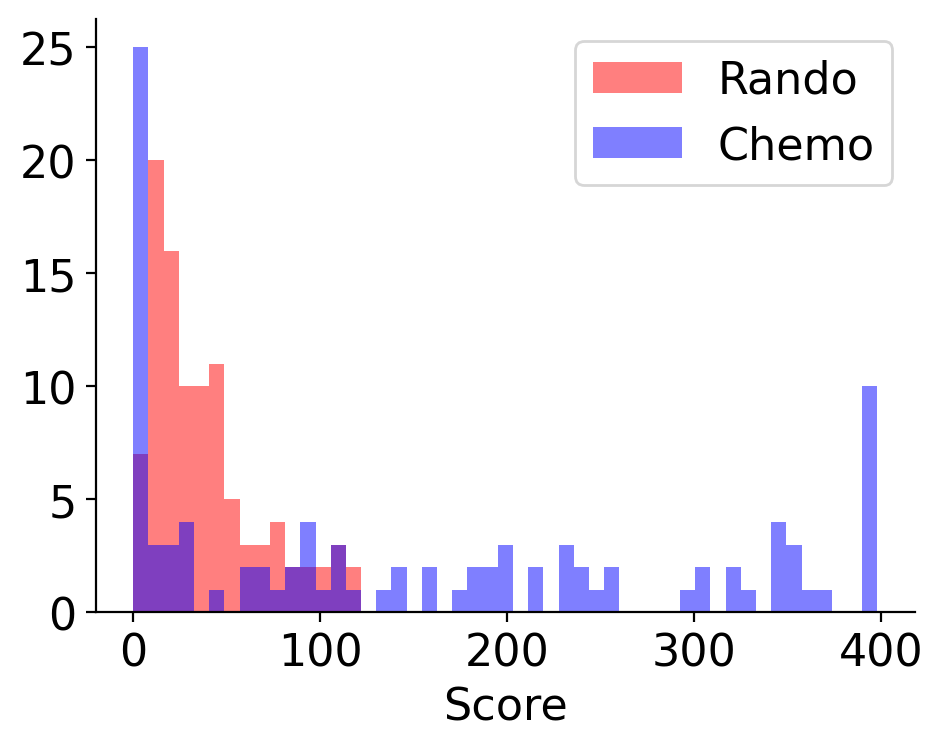

In [21]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 2.1

How do each of our agents perform across the performance measures we have chosen?

In [22]:
# Write your answer here as a comment. Explain yourself.

## Section 3 - Robustness of information searching

In this final section we will see how the distortion in the channel driven by missing signal influences the efficiency of our chemo agent.

Here we will test a range of *p_scent* values. Essentially we will be turning *down* the distortion as *p_scent* increases. For these experiments we will hold the *noise_sigma* constant at 1.

In [23]:
# Our parameters
p_scents = [0.05, 0.25, .50, .75, .95]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = p_scents # list(range(5))

Let's run these experiments. All of the parameters for the agent and environment (aside from *p_scent*) are specified below.

In [24]:
# Define the accumulation parameters
drift_rate = 1
threshold = 3
accumulate_sigma = 1.0

# Define non-scent probability values
noise_sigma = 1
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 100

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)

# Run
results = []

for i, p_scent in zip(names, p_scents):
  # Targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # Scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # Env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )

  results.append(exp)


chemo:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

Now let us take a look at the performance of our agent across runs.

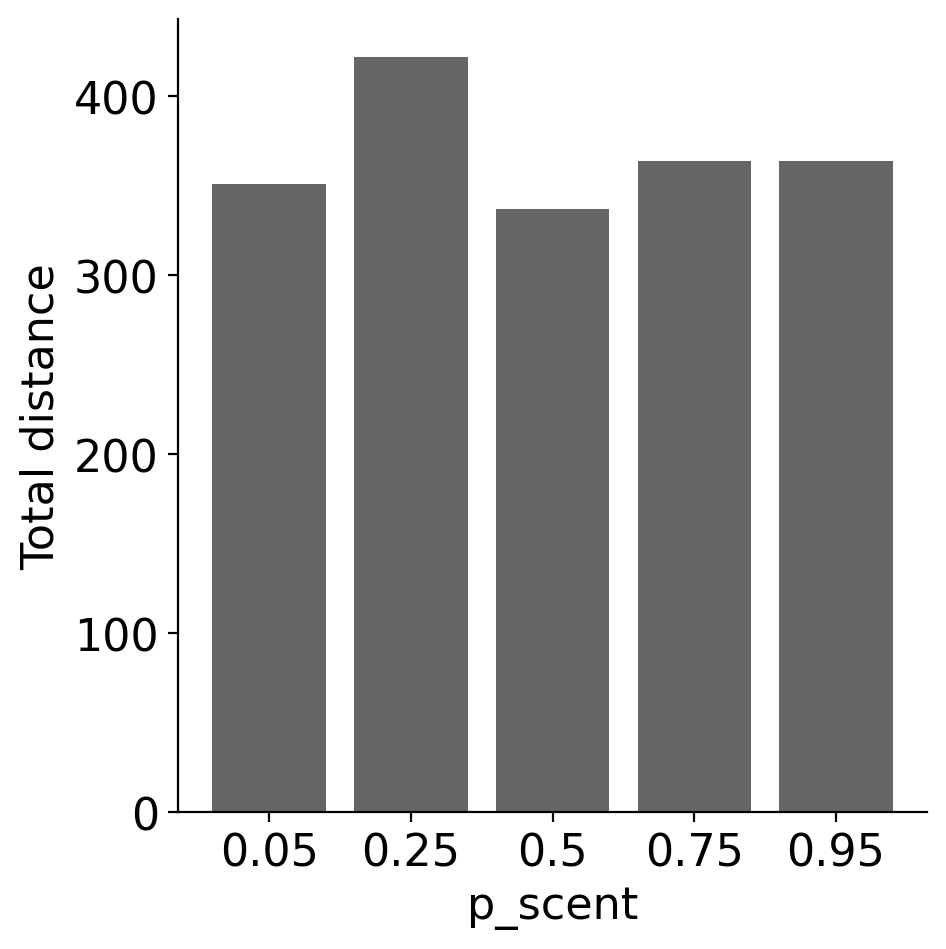

In [25]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

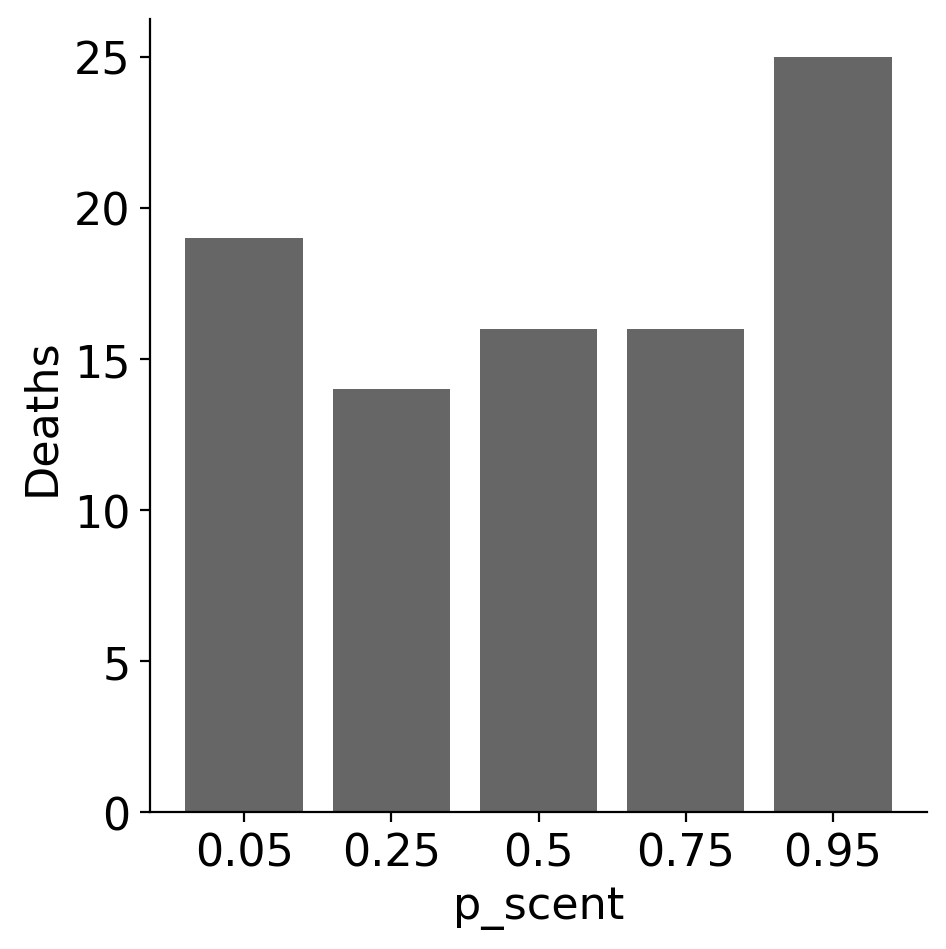

In [26]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

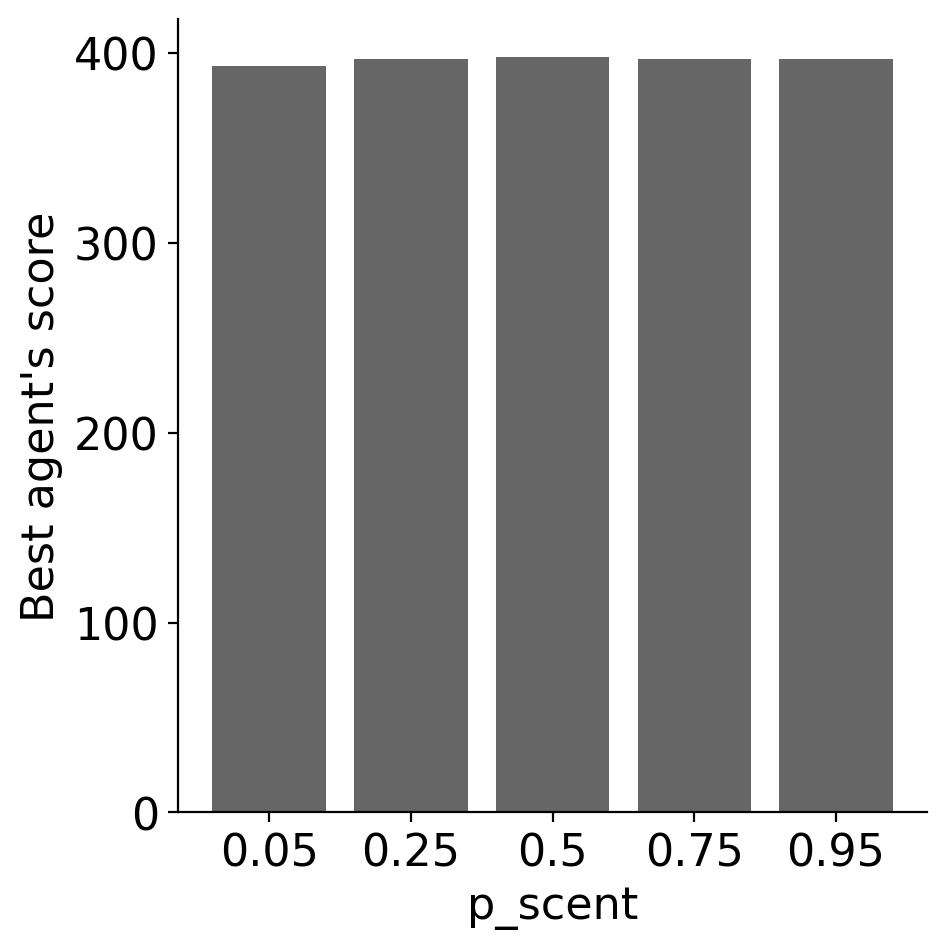

In [27]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

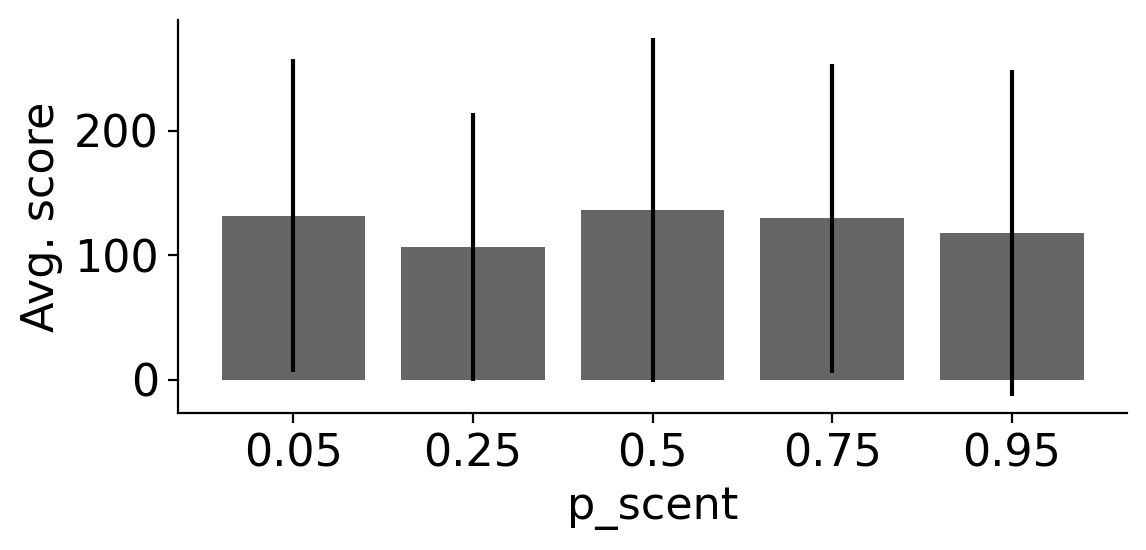

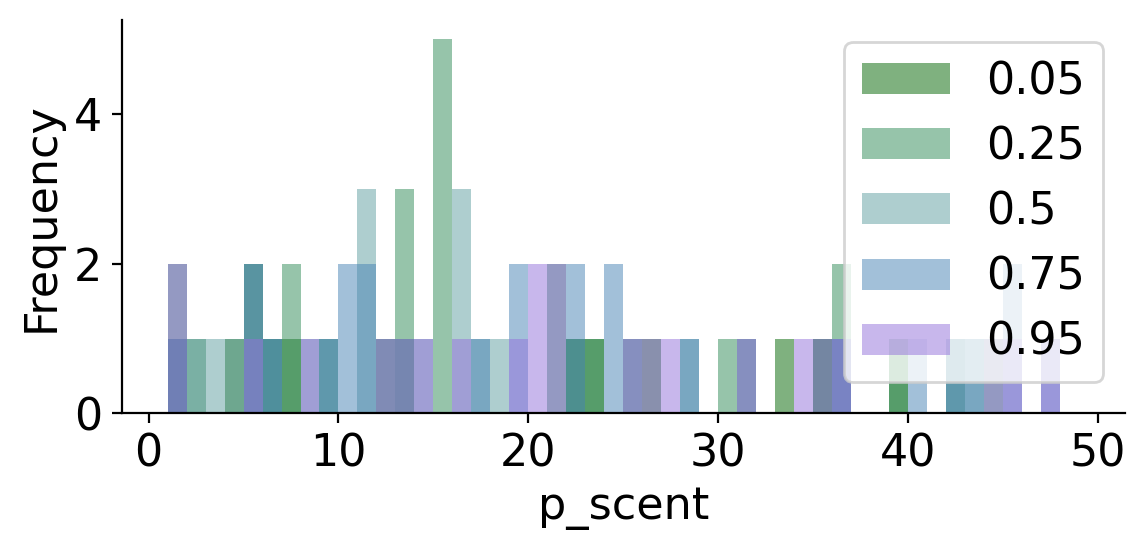

In [28]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("p_scent")
    plt.tight_layout()
    sns.despine()

### Question 3.1

How does increasing *p_scent* impact our chemo agent's performance? Explain why this particular pattern emerges in the results.

In [29]:
# Write your answer here as a comment. Explain yourself.

### Question 3.2

Re-run the simulations from this section, but now change the accumulation rate (*drift_rate*) from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher accumulation rate)?

In [30]:
# Write your answer here as a comment. Explain yourself.